# Comparison of Classifiers: k-fold + ROC AUC scores

Let's do the following: do a k-fold of ROC AUC, and compare the scores with a Wilcoxon test.

I check it ten times to assess its variability.

First, let's load the Breast Cancer Dataset. We will construct two RandomForest with 50 and 51 estimators with the hope that there is no real difference between them

## Problems of this test:

- Lack of independence: Each pair of training sets share 80% of their examples, so the conditions of a t-test, Wilcoxon and others is not met


## References

1. Dietterich, T. G. (1998). Approximate statistical tests for comparing supervised classification learning algorithms. Neural computation, 10(7), 1895-1923.
2. Bifet (2005), Efficient Online Evaluation of Big Data Stream Classifiers.
3. Demšar, J. (2006). Statistical comparisons of classifiers over multiple data sets. Journal of Machine learning research, 7(Jan), 1-30.

In [1]:
import sklearn
import numpy as np
import scipy
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris, load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split

from __future__ import print_function
from IPython.core.debugger import Tracer

dataset = load_breast_cancer()

data = dataset.data
target = dataset.target



In [2]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics.scorer import check_scoring

def _get_score(clf, X_train, y_train, X_test, y_test, scoring):
    clf.fit(X_train, y_train)
    
    scorer = check_scoring(clf, scoring=scoring)

    return scorer(clf, X_test, y_test)


def k_fold_compare(clfA, clfB, data, target, cv, scoring='roc_auc'):
    pval = None
    splitter = StratifiedKFold(n_splits=cv)

    score_A = []
    score_B = []

    for train_index, test_index in splitter.split(data, target):
        X_train, y_train = data[train_index], target[train_index]
        X_test, y_test = data[test_index], target[test_index]

        score_A.append(_get_score(clfA, X_train, y_train, X_test, y_test, scoring=scoring))
        score_B.append(_get_score(clfB, X_train, y_train, X_test, y_test, scoring=scoring))

    pval = scipy.stats.wilcoxon(score_A, score_B).pvalue
    
    return pval

In [3]:
for i in range(100):
    pval = k_fold_compare(
        RandomForestClassifier(n_estimators=50), 
        RandomForestClassifier(n_estimators=51), 
        data, 
        target,
        cv=10
    )
    if pval < 0.05:
        print("Type I error: {}-iteration - pval = {}".format(i, pval))

/home/jmperez/.pyenv/versions/2.7.12/envs/aprendizaje/lib/python2.7/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


Type I error: 40-iteration - pval = 0.035465864624
Type I error: 50-iteration - pval = 0.0425224779981
Type I error: 56-iteration - pval = 0.0179604775261
Type I error: 70-iteration - pval = 0.0499499764547
Type I error: 87-iteration - pval = 0.035465864624


In [4]:
for i in range(100):
    pval = k_fold_compare(
        RandomForestClassifier(n_estimators=50), 
        RandomForestClassifier(n_estimators=51), 
        data, 
        target,
        scoring='precision',
        cv=10
    )
    
    if pval < 0.05:
        print("Type I error: {}-iteration - pval = {}".format(i, pval))

Type I error: 25-iteration - pval = 0.0431144467831
Type I error: 40-iteration - pval = 0.0179604775261
Type I error: 42-iteration - pval = 0.0279918154857
Type I error: 45-iteration - pval = 0.0277078493581


/home/jmperez/.pyenv/versions/2.7.12/envs/aprendizaje/lib/python2.7/site-packages/scipy/stats/morestats.py:2413: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se


Type I error: 79-iteration - pval = 0.0431144467831
Type I error: 83-iteration - pval = 0.0463994618709


# Two different-performing classifiers


In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

clf_A = RandomForestClassifier(n_estimators=50)
clf_B = DecisionTreeClassifier(max_depth=2)


for i in range(20):
    pval = k_fold_compare(
        clf_A, 
        clf_B, 
        data, 
        target,
        cv=10
    )
    if pval > 0.05:
        print("Type II error: {}-iteration - pval = {}".format(i, pval))
    else:
        print("Rejecting null hypothesis (pval = {})".format(pval))

Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting null hypothesis (pval = 0.00691042980781)
Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting null hypothesis (pval = 0.00768579405521)
Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting null hypothesis (pval = 0.00768579405521)
Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting null hypothesis (pval = 0.00506203212627)
Rejecting nu

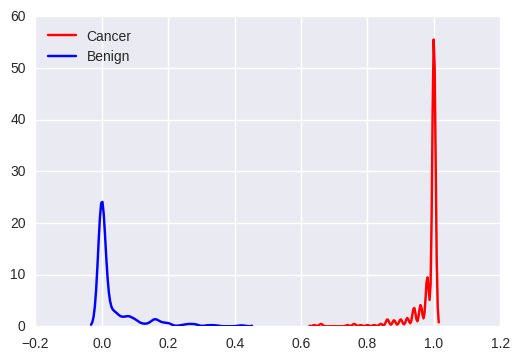

In [20]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

clf_A.fit(data, target)
clf_B.fit(data, target)

def distplot(clf, data, target):
    prob = clf.predict_proba(data)[:, 1]
    sns.distplot(prob[target==1], color="red", label="Cancer", hist=False)
    sns.distplot(prob[target==0], color="blue", label="Benign", hist=False)
#p = np.random.random(100) / 2.0 + np.array(40*[0] + 60*[0.5])  # posteriors modelo 1
#p2 = np.random.random(100) # posteriors modelo 2
#y = np.array(["Gato"]*60 + ["Perro"]*40) # labels

distplot(clf_A, data, target)